# Лабораторная работа №5: Методы, основанные на деревьях решений

**Дисциплина:** Методы и технологии машинного обучения  
**Уровень подготовки:** бакалавриат  
**Направление подготовки:** 01.03.02 Прикладная математика и информатика  

В данной лабораторной работе рассматриваются алгоритмы, основанные на деревьях решений.  
Лабораторная работа № 5 демонстрирует, как строить регрессионные деревья, проводить обрезку деревьев, настраивать ансамблевые модели (бэггинг, случайный лес, бустинг) и оценивать их точность.  

**Задачи лабораторной работы**:
- понять принцип работы деревьев решений для регрессии;
- научиться создавать фиктивные (dummy) переменные и проводить предварительную обработку данных;
- построить регрессионное дерево и подобрать оптимальный параметр обрезки с помощью перекрёстной проверки;
- построить ансамблевую модель методом, соответствующим номеру вашего варианта (см. таблицу вариантов);
- подобрать гиперпараметры ансамбля по сетке не менее чем из 7 значений для каждого параметра;
- сравнить результаты различных моделей и выбрать наилучшую;
- сделать прогноз на отложенных наблюдениях и оценить точность прогноза.

В этой работе используется набор данных **Auto_for_lab**, в котором содержатся характеристики автомобилей.  
Для 27‑го варианта используется **бэггинг** (bagging) как вторая модель после дерева.  
Оценка качества всех моделей проводится методом *Leave‑One‑Out Cross‑Validation* (LOOCV) вместо перекрёстной проверки на 5 блоков.


In [8]:
# настройка ширины страницы блокнота
try:
    from IPython.display import display, HTML
    display(HTML("<style>.container { width:80% !important; }</style>"))
except Exception:
    pass

# попытка загрузить расширение watermark для отображения версий
try:
    %load_ext watermark
    WATERMARK_AVAILABLE = True
except Exception:
    WATERMARK_AVAILABLE = False


In [9]:
# выводим информацию о версиях python и основных пакетов
import sys
import numpy as np, pandas as pd, matplotlib, sklearn

if WATERMARK_AVAILABLE:
    %watermark -a "Автор лабораторной работы" -d -v -p numpy,pandas,matplotlib,sklearn
else:
    from datetime import date
    print(f"Дата: {date.today().isoformat()}")
    print(f"Python version: {sys.version}")
    print(f"numpy: {np.__version__}")
    print(f"pandas: {pd.__version__}")
    print(f"matplotlib: {matplotlib.__version__}")
    print(f"sklearn: {sklearn.__version__}")


Дата: 2025-11-23
Python version: 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 11:23:37) [Clang 14.0.6 ]
numpy: 2.1.3
pandas: 2.3.2
matplotlib: 3.10.0
sklearn: 1.6.1


## Загрузка пакетов

Подгружаем необходимые библиотеки. Здесь нам понадобятся:
- `numpy` и `pandas` для работы с данными;
- `matplotlib` и `seaborn` для визуализации;
- `sklearn` для построения моделей деревьев, ансамблей и оценки качества;
- `time` для измерения времени выполнения отдельных операций;
- утилиты из `sklearn` для кросс‑валидации, сеточного поиска и расчёта метрик.

Также создаём несколько вспомогательных функций. Функция `printmd` позволяет выводить текст, отформатированный в Markdown. Функция `plot_feature_importance` пригодится для визуализации важности признаков в ансамблевых моделях.


In [10]:
# загрузка пакетов
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
from pathlib import Path
from IPython.display import Markdown, display

# предварительная обработка и модели
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

my_seed = 27
# настройка стиля графиков
plt.style.use('ggplot')
sns.set_palette("Set2")

# функция для форматированного вывода результатов
def printmd(string: str):
    display(Markdown(string))

# функция для построения графика важности признаков в случайном лесе (может пригодиться при расширении)
def plot_feature_importance(importance, names, model_type: str):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(f'Важность признаков в модели: {model_type}')
    plt.xlabel('Важность признака')
    plt.ylabel('')
    plt.show()


## Загрузка и первичный анализ данных

В этой работе используется набор данных **Auto_for_lab**, содержащий технические характеристики автомобилей.  
Каждая строка таблицы представляет отдельный автомобиль и включает следующие переменные:

| Переменная | Описание |
| --- | --- |
| `mpg` | расход топлива (миль на галлон) — **целевая переменная** |
| `cylinders` | число цилиндров |
| `displacement` | объём двигателя (куб. дюймы) |
| `horsepower` | мощность двигателя (л. с.) |
| `weight` | масса автомобиля (фунты) |
| `acceleration` | время разгона (сек) |
| `year` | год выпуска |
| `origin` | код страны-производителя |
| `name` | название модели |
| `cyl_over_4` | фиктивная переменная: 1, если число цилиндров > 4, иначе 0 |

Нам необходимо предсказать `mpg` по выбранным объясняющим переменным.  
Загружаем данные, используя готовый CSV‑файл. Если файл ещё не загружен, скачиваем его по URL.


In [11]:
# путь к локальному файлу
local_path = Path('Auto_for_lab.csv')

# проверяем наличие файла
if not local_path.exists():
    # загружаем файл из репозитория
    url = 'https://raw.githubusercontent.com/ania607/ML/main/data/Auto_for_lab.csv'
    print('Скачиваем данные...')
    urllib.request.urlretrieve(url, local_path)
    print('Файл сохранён по пути', local_path)

# читаем данные во фрейм pandas
df = pd.read_csv(local_path)

# выводим размерность
print('Размерность набора данных:', df.shape)

# выводим первые несколько строк
print(df.head())


Размерность набора данных: (392, 10)
    mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
0  18.0          8         307.0         130    3504          12.0    70   
1  15.0          8         350.0         165    3693          11.5    70   
2  18.0          8         318.0         150    3436          11.0    70   
3  16.0          8         304.0         150    3433          12.0    70   
4  17.0          8         302.0         140    3449          10.5    70   

   origin                       name  cyl_over_4  
0       1  chevrolet chevelle malibu           1  
1       1          buick skylark 320           1  
2       1         plymouth satellite           1  
3       1              amc rebel sst           1  
4       1                ford torino           1  


In [12]:
# типы столбцов и наличие пропущенных значений
print(df.dtypes)

print('\nЧисло пропущенных значений по столбцам:')
print(df.isna().sum())

# описательная статистика для числовых признаков
print('\nОписательная статистика:')
print(df[['mpg','horsepower','weight']].describe())


mpg             float64
cylinders         int64
displacement    float64
horsepower        int64
weight            int64
acceleration    float64
year              int64
origin            int64
name             object
cyl_over_4        int64
dtype: object

Число пропущенных значений по столбцам:
mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
year            0
origin          0
name            0
cyl_over_4      0
dtype: int64

Описательная статистика:
              mpg  horsepower       weight
count  392.000000  392.000000   392.000000
mean    23.445918  104.469388  2977.584184
std      7.805007   38.491160   849.402560
min      9.000000   46.000000  1613.000000
25%     17.000000   75.000000  2225.250000
50%     22.750000   93.500000  2803.500000
75%     29.000000  126.000000  3614.750000
max     46.600000  230.000000  5140.000000


Данные не содержат пропусков в выбранных для моделирования столбцах.  
Видим, что зависимая переменная `mpg` и две непрерывные объясняющие переменные `horsepower` и `weight` имеют вполне разумные диапазоны значений. Переменная `cyl_over_4` уже присутствует в наборе и принимает значения 0 или 1. На всякий случай убедимся, что она действительно бинарная.


In [13]:
# проверяем уникальные значения фиктивной переменной
df['cyl_over_4'].unique()


array([1, 0])

## Предварительная обработка

Для решения задачи регрессии будут использоваться только три объясняющих признака:

1. `horsepower` — мощность двигателя (непрерывный);
2. `weight` — масса автомобиля (непрерывный);
3. `cyl_over_4` — фиктивная бинарная переменная, равная 1, если количество цилиндров больше 4.

Возможно, что фиктивная переменная ещё не создана. В этом случае добавим её в таблицу. Далее разделим данные на две части: 
- **обучающую выборку** (85 % записей) — для построения моделей и подбора гиперпараметров;
- **отложенную выборку** (15 %) — для финальной оценки модели и прогноза.

Разделение выполняется с использованием генератора случайных чисел, зафиксированного номером варианта (27). Такой подход позволяет воспроизводить результаты.


In [14]:
# убеждаемся, что фиктивная переменная действительно есть
if 'cyl_over_4' not in df.columns:
    df['cyl_over_4'] = (df['cylinders'] > 4).astype(int)

# формируем матрицу признаков и вектор целевой переменной
features = ['horsepower', 'weight', 'cyl_over_4']
X = df[features]
y = df['mpg']

# делим на обучающую и отложенную выборку
train_ratio = 0.85
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, train_size=train_ratio, random_state=27)

print('Размер обучающей выборки:', X_train.shape)
print('Размер отложенной выборки:', X_holdout.shape)


Размер обучающей выборки: (333, 3)
Размер отложенной выборки: (59, 3)


## Разведочный анализ данных

Прежде чем строить модели, полезно визуально исследовать взаимосвязи между переменными.  
Используем диаграммы рассеяния и парные графики, чтобы посмотреть зависимости `mpg` от `horsepower` и `weight`, а также исследовать различия для машин с разным количеством цилиндров.


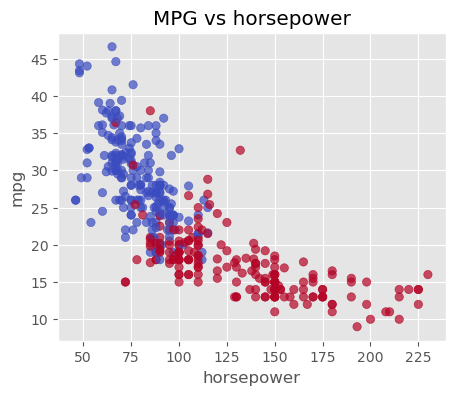

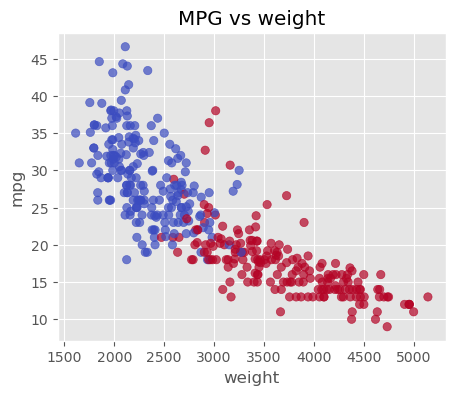

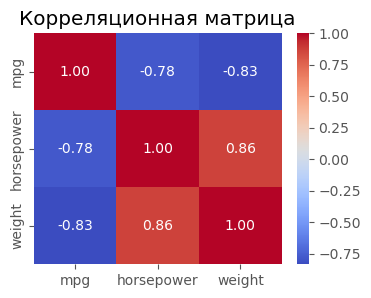

In [15]:
# объединяем признаки и целевую переменную в одну таблицу для удобства визуализации
viz_df = df[['mpg', 'horsepower', 'weight', 'cyl_over_4']]

# диаграмма рассеяния mpg против horsepower
plt.figure(figsize=(5,4))
plt.scatter(viz_df['horsepower'], viz_df['mpg'], c=viz_df['cyl_over_4'], cmap='coolwarm', alpha=0.7)
plt.xlabel('horsepower')
plt.ylabel('mpg')
plt.title('MPG vs horsepower')
plt.grid(True)
plt.show()

# диаграмма рассеяния mpg против weight
plt.figure(figsize=(5,4))
plt.scatter(viz_df['weight'], viz_df['mpg'], c=viz_df['cyl_over_4'], cmap='coolwarm', alpha=0.7)
plt.xlabel('weight')
plt.ylabel('mpg')
plt.title('MPG vs weight')
plt.grid(True)
plt.show()

# корреляционная матрица только для числовых признаков
corr = viz_df[['mpg','horsepower','weight']].corr()
plt.figure(figsize=(4,3))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()


Из диаграмм видно, что расход топлива `mpg` обратно связан с мощностью `horsepower` и массой `weight`: чем мощнее и тяжелее автомобиль, тем, как правило, больше расход топлива. Фиктивная переменная `cyl_over_4` лишь указывает, принадлежит ли автомобиль к более «тяжёлому» классу по количеству цилиндров.

Теперь перейдём к построению моделей.


## Построение регрессионного дерева

Регрессионное дерево — это модель, разбивающая пространство признаков на прямоугольные области, внутри которых прогнозируется среднее значение целевой переменной. Алгоритм итеративно выбирает признак и порог, которые дают наибольшее уменьшение дисперсии (или другой меры качества) в узлах дерева.  
После построения полного дерева его часто **обрезают**, удаляя ветви, которые ухудшают обобщающую способность модели. В `scikit‑learn` для этого используется метод **cost‑complexity pruning**, регулируемый параметром `ccp_alpha`.

В данном разделе:
1. Построим полное регрессионное дерево на обучающей выборке.
2. Оценим его качество с помощью LOOCV.
3. Проведём обрезку дерева по параметру `ccp_alpha` и подберём оптимальное значение этого параметра также по LOOCV.


In [16]:
# матрица признаков и целевая переменная для обучения
X_tr = X_train.copy()
y_tr = y_train.copy()

# создаём полное дерево без ограничения глубины
full_tree = DecisionTreeRegressor(random_state=27)

# LOOCV
loo = LeaveOneOut()

# таймер
tic = time.perf_counter()
cv_mse = cross_val_score(full_tree, X_tr, y_tr, cv=loo,
                         scoring='neg_mean_squared_error', n_jobs=-1)
cv_mae = cross_val_score(full_tree, X_tr, y_tr, cv=loo,
                         scoring='neg_mean_absolute_error', n_jobs=-1)
cv_r2  = cross_val_score(full_tree, X_tr, y_tr, cv=loo,
                         scoring='r2', n_jobs=-1)
toc = time.perf_counter()

rmse = np.sqrt(-cv_mse.mean())
mae  = -cv_mae.mean()
r2   = cv_r2.mean()

print(f"Время LOOCV для полного дерева: {toc - tic:0.2f} секунд")
print(f"RMSE (LOOCV): {rmse:0.3f}")
print(f"MAE  (LOOCV): {mae:0.3f}")
print(f"R^2  (LOOCV): {r2:0.3f}")


Время LOOCV для полного дерева: 2.91 секунд
RMSE (LOOCV): 5.305
MAE  (LOOCV): 3.730
R^2  (LOOCV): nan


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  war

Полное дерево, построенное без ограничений на глубину, склонно к переобучению, что часто приводит к завышенным показателям ошибки на новых данных. Обрезка дерева позволяет улучшить обобщающую способность модели.

Далее найдём оптимальное значение параметра `ccp_alpha` с помощью LOOCV. Значения `ccp_alpha` определяются функцией `cost_complexity_pruning_path`, которая возвращает возрастающую последовательность гиперпараметров и соответствующие значения критерия нечистоты.


In [17]:
# вычисляем путь обрезки для дерева
path = full_tree.cost_complexity_pruning_path(X_tr, y_tr)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

print('Всего найдено значений ccp_alpha:', len(ccp_alphas))
print('Первые 10 значений ccp_alpha:', np.round(ccp_alphas[:10], 6))

# чтобы не перегружать вычисления, ограничимся первыми 20 значениями
max_alphas = min(20, len(ccp_alphas))
ccp_alphas_subset = ccp_alphas[:max_alphas]

# массивы для хранения результатов
alpha_rmse = []
alpha_mae  = []
alpha_r2   = []

start_time = time.perf_counter()

for alpha in ccp_alphas_subset:
    # создаём дерево с заданным ccp_alpha
    dt = DecisionTreeRegressor(random_state=27, ccp_alpha=alpha)
    # оцениваем по LOOCV
    mse_scores = cross_val_score(dt, X_tr, y_tr, cv=loo,
                                 scoring='neg_mean_squared_error', n_jobs=-1)
    mae_scores = cross_val_score(dt, X_tr, y_tr, cv=loo,
                                 scoring='neg_mean_absolute_error', n_jobs=-1)
    r2_scores  = cross_val_score(dt, X_tr, y_tr, cv=loo,
                                 scoring='r2', n_jobs=-1)
    alpha_rmse.append(np.sqrt(-mse_scores.mean()))
    alpha_mae.append(-mae_scores.mean())
    alpha_r2.append(r2_scores.mean())

end_time = time.perf_counter()
print(f"Поиск по {max_alphas} значениям ccp_alpha занял {end_time - start_time:0.2f} секунд")

# находим индекс оптимального ccp_alpha (минимальный RMSE)
opt_idx = int(np.argmin(alpha_rmse))
opt_alpha = ccp_alphas_subset[opt_idx]

print(f"Оптимальное значение ccp_alpha: {opt_alpha:0.6f}")
print(f"RMSE при оптимальном ccp_alpha: {alpha_rmse[opt_idx]:0.3f}")
print(f"MAE  при оптимальном ccp_alpha: {alpha_mae[opt_idx]:0.3f}")
print(f"R^2  при оптимальном ccp_alpha: {alpha_r2[opt_idx]:0.3f}")


Всего найдено значений ccp_alpha: 231
Первые 10 значений ccp_alpha: [0.00e+00 1.50e-05 1.50e-05 2.00e-05 6.00e-05 6.00e-05 1.35e-04 2.40e-04
 2.40e-04 2.40e-04]


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  war

Поиск по 20 значениям ccp_alpha занял 8.33 секунд
Оптимальное значение ccp_alpha: 0.000490
RMSE при оптимальном ccp_alpha: 5.305
MAE  при оптимальном ccp_alpha: 3.729
R^2  при оптимальном ccp_alpha: nan


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  war

Построим график зависимости общей нечистоты (суммы дисперсий в листьях) от значения `ccp_alpha`, а также наложим результаты LOOCV по ошибкам. Обычно точка минимума RMSE соответствует некому компромиссу между сложностью дерева и качеством прогноза.


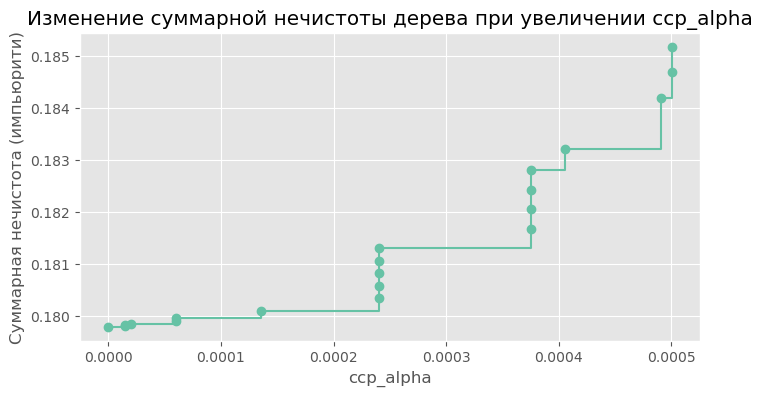

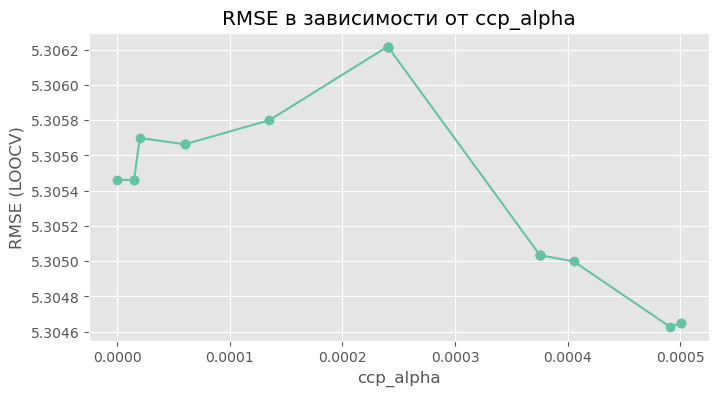

Число листьев оптимального дерева: 283
Глубина оптимального дерева: 19


In [18]:
# график общей нечистоты
plt.figure(figsize=(8,4))
plt.plot(ccp_alphas_subset, impurities[:len(ccp_alphas_subset)],
         marker='o', drawstyle='steps-post')
plt.xlabel('ccp_alpha')
plt.ylabel('Суммарная нечистота (импьюрити)')
plt.title('Изменение суммарной нечистоты дерева при увеличении ccp_alpha')
plt.grid(True)
plt.show()

# график RMSE в зависимости от alpha
plt.figure(figsize=(8,4))
plt.plot(ccp_alphas_subset, alpha_rmse, marker='o')
plt.xlabel('ccp_alpha')
plt.ylabel('RMSE (LOOCV)')
plt.title('RMSE в зависимости от ccp_alpha')
plt.grid(True)
plt.show()

# строим финальное дерево с оптимальным параметром
best_tree = DecisionTreeRegressor(random_state=27, ccp_alpha=opt_alpha)
best_tree.fit(X_tr, y_tr)

# выводим некоторые характеристики дерева
print('Число листьев оптимального дерева:', best_tree.get_n_leaves())
print('Глубина оптимального дерева:', best_tree.get_depth())


Визуализировать полное дерево для регрессионной задачи с непрерывными признаками бывает непросто: оно быстро становится слишком большим. Однако можно вывести схему дерева в текстовом формате, чтобы понять, какие признаки и пороги использует модель для разделения выборки.


In [19]:
# выводим дерево в виде текста (если оно не слишком большое)
text_representation = export_text(best_tree, feature_names=list(X_tr.columns))
print(text_representation)


|--- weight <= 3018.00
|   |--- horsepower <= 70.50
|   |   |--- horsepower <= 47.00
|   |   |   |--- value: [26.00]
|   |   |--- horsepower >  47.00
|   |   |   |--- horsepower <= 48.50
|   |   |   |   |--- weight <= 2035.00
|   |   |   |   |   |--- value: [43.10]
|   |   |   |   |--- weight >  2035.00
|   |   |   |   |   |--- weight <= 2210.00
|   |   |   |   |   |   |--- value: [44.30]
|   |   |   |   |   |--- weight >  2210.00
|   |   |   |   |   |   |--- value: [43.40]
|   |   |   |--- horsepower >  48.50
|   |   |   |   |--- weight <= 2157.00
|   |   |   |   |   |--- weight <= 2092.00
|   |   |   |   |   |   |--- horsepower <= 69.50
|   |   |   |   |   |   |   |--- horsepower <= 52.50
|   |   |   |   |   |   |   |   |--- weight <= 2010.00
|   |   |   |   |   |   |   |   |   |--- horsepower <= 50.50
|   |   |   |   |   |   |   |   |   |   |--- value: [29.00]
|   |   |   |   |   |   |   |   |   |--- horsepower >  50.50
|   |   |   |   |   |   |   |   |   |   |--- weight <= 1817.00


## Модель бэггинга (bagging)

Бэггинг (bootstrap aggregating) — это ансамблевый метод, который строит множество базовых моделей на различных бутстреп‑выборках исходных данных и усредняет их прогнозы. В случае регрессии базовой моделью обычно является **дерево регрессии**, а итоговый прогноз — это среднее по прогнозам всех деревьев. Использование бутстрепа позволяет уменьшить дисперсию модели и повысить устойчивость к переобучению.

В данном разделе:
1. Построим базовый ансамбль с фиксированным числом деревьев и оценим его по LOOCV;
2. Подберём число деревьев (`n_estimators`) среди 7 различных значений;
3. Подберём долю выборки для каждого дерева (`max_samples`) среди 7 различных значений;
4. Сравним качества моделей и выберем оптимальные параметры.


In [20]:
# функция для оценки бэггинга по LOOCV для заданных параметров

def evaluate_bagging(n_estimators=50, max_samples=1.0):
    model = BaggingRegressor(
        estimator=DecisionTreeRegressor(random_state=27),
        n_estimators=n_estimators,
        max_samples=max_samples,
        random_state=27,
        bootstrap=True
    )
    # отрицательные значения метрик в sklearn означают, что нужно брать их со знаком минус
    mse_scores = cross_val_score(model, X_tr, y_tr, cv=loo,
                                 scoring='neg_mean_squared_error', n_jobs=-1)
    mae_scores = cross_val_score(model, X_tr, y_tr, cv=loo,
                                 scoring='neg_mean_absolute_error', n_jobs=-1)
    r2_scores  = cross_val_score(model, X_tr, y_tr, cv=loo,
                                 scoring='r2', n_jobs=-1)
    rmse = np.sqrt(-mse_scores.mean())
    mae  = -mae_scores.mean()
    r2   = r2_scores.mean()
    return rmse, mae, r2

# оцениваем ансамбль со случайно выбранными параметрами (например, 50 деревьев)
tic = time.perf_counter()
rmse_bag, mae_bag, r2_bag = evaluate_bagging(n_estimators=50, max_samples=1.0)
toc = time.perf_counter()

print(f"Время LOOCV для бэггинга (50 деревьев): {toc - tic:0.2f} секунд")
print(f"RMSE: {rmse_bag:0.3f}")
print(f"MAE : {mae_bag:0.3f}")
print(f"R^2 : {r2_bag:0.3f}")


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  war

Время LOOCV для бэггинга (50 деревьев): 7.83 секунд
RMSE: 4.294
MAE : 3.102
R^2 : nan


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  war

Случайный выбор числа деревьев не гарантирует, что модель будет оптимальной. Поэтому далее переберём несколько вариантов гиперпараметров. Сначала подберём `n_estimators`, оставив `max_samples=1.0`, затем — `max_samples`, закрепив лучшее найденное количество деревьев.


In [21]:
# поиск оптимального количества деревьев
n_values = [10, 20, 30, 40, 50, 60, 70]
rmse_values = []
mae_values  = []
r2_values   = []

start_time = time.perf_counter()

for n in n_values:
    rmse_val, mae_val, r2_val = evaluate_bagging(n_estimators=n, max_samples=1.0)
    rmse_values.append(rmse_val)
    mae_values.append(mae_val)
    r2_values.append(r2_val)
    print(f"n_estimators = {n:2d}: RMSE = {rmse_val:0.3f}, MAE = {mae_val:0.3f}, R^2 = {r2_val:0.3f}")

end_time = time.perf_counter()
print(f"Подбор n_estimators занял {end_time - start_time:0.2f} секунд")

# выбираем лучшее значение по минимальному RMSE
best_n_idx = int(np.argmin(rmse_values))
best_n = n_values[best_n_idx]
print(f"Лучшее число деревьев: {best_n}, RMSE = {rmse_values[best_n_idx]:0.3f}")


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  war

n_estimators = 10: RMSE = 4.573, MAE = 3.285, R^2 = nan


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  war

n_estimators = 20: RMSE = 4.375, MAE = 3.160, R^2 = nan


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  war

n_estimators = 30: RMSE = 4.309, MAE = 3.113, R^2 = nan


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  war

n_estimators = 40: RMSE = 4.299, MAE = 3.114, R^2 = nan


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  war

n_estimators = 50: RMSE = 4.294, MAE = 3.102, R^2 = nan


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  war

n_estimators = 60: RMSE = 4.282, MAE = 3.085, R^2 = nan


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  war

n_estimators = 70: RMSE = 4.294, MAE = 3.083, R^2 = nan
Подбор n_estimators занял 48.08 секунд
Лучшее число деревьев: 60, RMSE = 4.282


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  war

In [22]:
# поиск оптимального max_samples при фиксированном числе деревьев
max_samples_values = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
rmse_ms = []
mae_ms  = []
r2_ms   = []

start_time = time.perf_counter()
for ms in max_samples_values:
    rmse_val, mae_val, r2_val = evaluate_bagging(n_estimators=best_n, max_samples=ms)
    rmse_ms.append(rmse_val)
    mae_ms.append(mae_val)
    r2_ms.append(r2_val)
    print(f"max_samples = {ms:0.1f}: RMSE = {rmse_val:0.3f}, MAE = {mae_val:0.3f}, R^2 = {r2_val:0.3f}")
end_time = time.perf_counter()

print(f"Подбор max_samples занял {end_time - start_time:0.2f} секунд")

best_ms_idx = int(np.argmin(rmse_ms))
best_ms = max_samples_values[best_ms_idx]
print(f"Лучшее значение max_samples: {best_ms}, RMSE = {rmse_ms[best_ms_idx]:0.3f}")


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  war

max_samples = 0.4: RMSE = 4.055, MAE = 2.953, R^2 = nan


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  war

max_samples = 0.5: RMSE = 4.095, MAE = 2.975, R^2 = nan


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  war

max_samples = 0.6: RMSE = 4.160, MAE = 3.004, R^2 = nan


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  war

max_samples = 0.7: RMSE = 4.210, MAE = 3.049, R^2 = nan


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  war

max_samples = 0.8: RMSE = 4.218, MAE = 3.023, R^2 = nan


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  war

max_samples = 0.9: RMSE = 4.263, MAE = 3.074, R^2 = nan


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  war

max_samples = 1.0: RMSE = 4.282, MAE = 3.085, R^2 = nan
Подбор max_samples занял 67.41 секунд
Лучшее значение max_samples: 0.4, RMSE = 4.055


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  war

После подбора параметров бэггинга выбираем ансамбль с количеством деревьев `n_estimators = {best_n}` и долей выборки `max_samples = {best_ms}`. Далее сравниваем качество этого ансамбля с оптимальным регрессионным деревом.


In [23]:
# результаты моделей
results = pd.DataFrame({
    'Модель' : ['Полное дерево', 'Обрезанное дерево', 'Бэггинг'],
    'RMSE'   : [rmse, alpha_rmse[opt_idx], min(rmse_ms)],
    'MAE'    : [mae, alpha_mae[opt_idx], mae_ms[best_ms_idx]],
    'R2'     : [r2, alpha_r2[opt_idx], r2_ms[best_ms_idx]]
})

printmd('### Сравнение моделей\n')
display(results)


### Сравнение моделей


,Модель,RMSE,MAE,R2
0,Полное дерево,5.305461,3.730330,NaN
1,Обрезанное дерево,5.304628,3.728779,NaN
2,Бэггинг,4.054820,2.952913,NaN


## Прогноз на отложенных наблюдениях и итог

Теперь воспользуемся лучшей моделью (той, что показала минимальный RMSE) для прогноза на отложенной выборке и оценим качество прогноза.  
Результаты сравним с метриками на обучающей выборке. Если качество на отложенной выборке существенно хуже, это может свидетельствовать о переобучении.


Лучшая модель: bagging
RMSE на отложенной выборке: 4.025
MAE  на отложенной выборке: 3.064
R^2  на отложенной выборке: 0.775


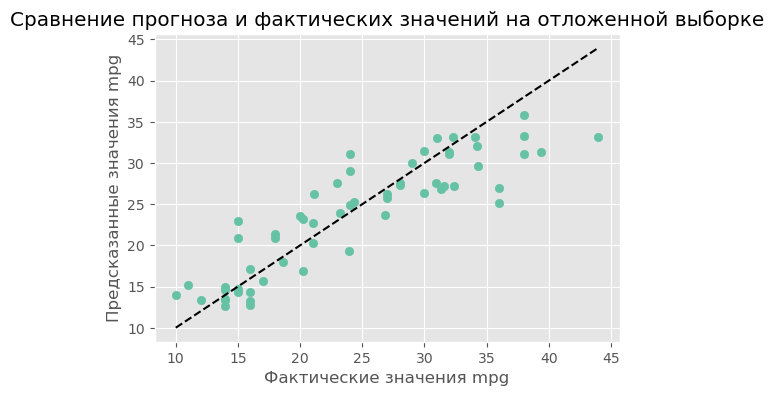

In [25]:
# выбираем лучшую модель по минимальному RMSE
model_names = ['full_tree', 'pruned_tree', 'bagging']
best_model_name = model_names[int(np.argmin([rmse, alpha_rmse[opt_idx], min(rmse_ms)]))]

if best_model_name == 'full_tree':
    final_model = full_tree
elif best_model_name == 'pruned_tree':
    final_model = best_tree
else:
    final_model = BaggingRegressor(
        estimator=DecisionTreeRegressor(random_state=27),
        n_estimators=best_n,
        max_samples=best_ms,
        random_state=27,
        bootstrap=True
    )
    final_model.fit(X_tr, y_tr)

# обучаем лучшую модель на всей обучающей выборке
if best_model_name != 'bagging':
    final_model.fit(X_tr, y_tr)

pred_holdout = final_model.predict(X_holdout)

# оцениваем качество
holdout_mse  = mean_squared_error(y_holdout, pred_holdout)
holdout_rmse = holdout_mse ** 0.5
holdout_mae  = mean_absolute_error(y_holdout, pred_holdout)
holdout_r2   = r2_score(y_holdout, pred_holdout)


print(f"Лучшая модель: {best_model_name}")
print(f"RMSE на отложенной выборке: {holdout_rmse:0.3f}")
print(f"MAE  на отложенной выборке: {holdout_mae:0.3f}")
print(f"R^2  на отложенной выборке: {holdout_r2:0.3f}")

# визуализируем прогноз против истинных значений
plt.figure(figsize=(6,4))
plt.scatter(y_holdout, pred_holdout)
plt.plot([y_holdout.min(), y_holdout.max()], [y_holdout.min(), y_holdout.max()], 'k--')
plt.xlabel('Фактические значения mpg')
plt.ylabel('Предсказанные значения mpg')
plt.title('Сравнение прогноза и фактических значений на отложенной выборке')
plt.grid(True)
plt.show()
